**kV Field Size - Threshold Method**

The following scripts aim to use a binary threshold mask to find the kV Field size. 

I will first input the data from google drive, follow by applying a Gaussian blur to reduce the noise in the image.

In [1]:
###################################
# import all the modules you need #
###################################
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os
!rm -r kV_Field_Analysis
!git clone --branch demo https://github.com/UCLHp/kV_Field_Analysis.git

rm: cannot remove 'kV_Field_Analysis': No such file or directory
Cloning into 'kV_Field_Analysis'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 78 (delta 2), reused 1 (delta 1), pack-reused 73
Unpacking objects: 100% (78/78), done.


In [2]:
#####################
# Inputing the data #
#####################
path = '/content/kV_Field_Analysis/*.bmp'

img = [] # raw image array
name = [] # labels for the image

# find all files and load them into img using a for loop
for fname in glob.glob(path):
    # labeling files
    name.append(fname[38:42])
    # reading files
    img.append(cv2.imread(fname, cv2.IMREAD_GRAYSCALE))
# convert the list into an array
img = np.array(img, dtype='float32')

#################
# Gaussian blur #
#################
# Applying Gaussian blur to all image
blur_img = [] # create an empty list
for i in range(img.shape[0]): # lopo through images
    blur_img.append(cv2.GaussianBlur(img[i,:,:],(21,21),0)) # blur with a 21x21 pixel kernel
# convert the list into an array
blur_img = np.array(blur_img)

This method will attempt to find the kV Field size by applying a binary threshold mask. 

The idea is that the kV Field will have an intensity above a certain threshold, so the mask will clearly map out the kV field. Then, you just need to find the edge of the mask and it should be the kV field. 

The function below will apply the mask and find the vertical edges (A and B) of the kV field. I believe I have documented the function pretty well, so please refer to the function documentation for how the script works. 

In [3]:
def find_v_edge(image, low_threshold):
    """ 
    This function will take an an 8 bit grayscale image and output a 
    threshold image. It will also find two pairs of arrays that define the front
    and rear vertical edges of the kV field.

    input:
        image:         input image, where image must be an 8 bit grayscale image

        low_threshold: pixel intensity threshold, where any pixel value 
                       lower than this threshold will be set to 0

    output: 
        thresh_img:    array of the binary threshold image

        front_v_edge:  array of the horizontal pixel index position of the front
                       vertical edge

        rear_v_edge:   array of the horizontal pixel index position of the rear
                       vertical edge

        front_pos:     array of the vertical pixel index position of the front
                       vertical edge 

        rear_pos:      array of the vertical pixel index position of the rear
                       vertical edge                       
    """
    # Turning input image to a threshold image
    ret, thresh_img = cv2.threshold(image, low_threshold, 255, cv2.THRESH_BINARY) # the lower threshold can be set

    front_v_edge = [] # empty array for the vertical front edge (horizontal position)
    rear_v_edge = [] # empty array for the vertical rear edge (horizontal position)

    # Finding all points on the vertical edges of the thershold image
    for i in range(thresh_img.shape[0]): # going through the 1200 row
      cal = []
      if np.average(thresh_img[i]) == 0: # returning zeroes if no bright pixels could be found
        front_v_edge.append(0)
        rear_v_edge.append(0)
      else:
        cal = np.nonzero(thresh_img[i]) # finding all bright pixels within the row
        front_v_edge.append(cal[0][0]) # appending the first bright pixel
        rear_v_edge.append(cal[0][len(cal[0])-1]) # appending the last bright pixel

    # finding the upper bound of the front vertical edge
    for i in range(len(front_v_edge)):
      if front_v_edge[i] == 0:
        continue
      else:
        upper_front = i
        break
    # finding the lower bound of the front vertical edge
    for i in reversed(range(len(front_v_edge))):
      if rear_v_edge[i] == 0: 
        continue
      else:
        lower_front = i + 1
        break
    # finding the upper bound of the rear vertical edge
    for i in range(len(rear_v_edge)):
      if rear_v_edge[i] == 0:
        continue
      else:
        upper_rear = i
        break
    # finding the lower bound of the rear vertical edge
    for i in reversed(range(len(rear_v_edge))):
      if rear_v_edge[i] == 0: 
        continue
      else:
        lower_rear = i + 1
        # Final arrays of the front and rear edge
        front_v_edge = front_v_edge[upper_front:lower_front]
        rear_v_edge = rear_v_edge[upper_rear:lower_rear]

        # Arrays of the position of the edges
        front_pos = np.arange(upper_front,lower_front)
        rear_pos = np.arange(upper_rear,lower_rear)
        break

    return thresh_img, front_v_edge, rear_v_edge, front_pos, rear_pos

The code below was developed by Alex to find the isocentre of the kV field.

In [4]:
# average all images together and then extract profiles across small BBs 
avg_img = np.mean(img,0)
h_profile = np.mean(avg_img[603-4:603+4,:],0)
v_profile = np.mean(avg_img[:,799-4:799+4],1)

# find minima indices
a_idx = np.argmin(h_profile[400:500])+400
b_idx = np.argmin(h_profile[1100:1200])+1100
g_idx = np.argmin(v_profile[220:300])+220
t_idx = np.argmin(v_profile[900:995])+900

# calculate pixel size in mm
px_x = 200/(b_idx-a_idx)
px_y = 200/(t_idx-g_idx)
p2mm = (px_x+px_y)/2

# calculate laser centre
laser_isopx = np.array((a_idx + ((b_idx-a_idx)/2), g_idx + ((t_idx-g_idx)/2)))
laser_x, laser_y = laser_isopx

We need to find the horizontal edges (GT) as well. I use the vertical edges to define the boundaries of the horizontal edges, and I just use the same loops to find the vertical edges.

Finally, we can use the isocentres to find the kV field size from isocentre to the A, B, G and T edges. I plotted the results at the end of this script.

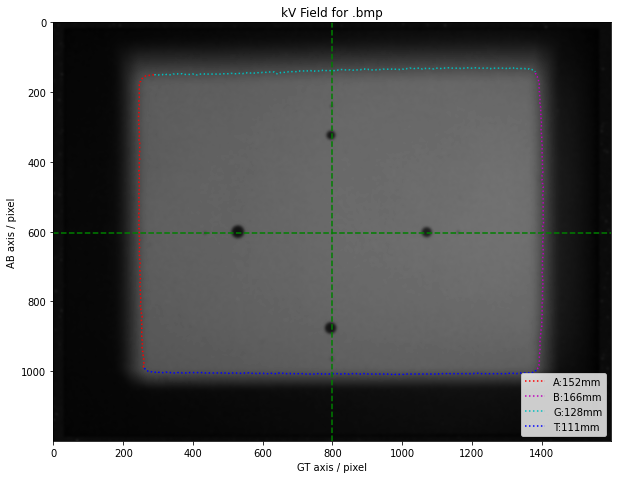


Field Sizes:

A-side = 152 mm
B-side = 166 mm
G-side = 128 mm
T-side = 111 mm


In [6]:
AField = []
BField = []
GField = []
TField = []

for img_no in np.arange(len(blur_img)):

  #image = np.ma.masked_array(blur_img[img_no], blur_img[img_no] < 3)
  #threshold = np.average(image)
  threshold = 22

  result, x_front, x_rear, y_front, y_rear = find_v_edge(blur_img[img_no],threshold)

  ##############################################################################
  # Slicing the vertical edge array to avoid overstreching, indices were found using visual inspection of data
  x_front = x_front[20:-18]
  y_front = y_front[20:-18]
  x_rear = x_rear[15:-15]
  y_rear = y_rear[15:-15]
  ############################################################################## 
  front_h_edge = []
  rear_h_edge = []

  # Finding all points on the horizontal edges of the thershold image
  result = result.transpose()
  for i in range(result.shape[0]): # going through the 1600 columns
    cal = []
    if np.average(result[i]) == 0: # returning zeroes if no bright pixels could be found
      front_h_edge.append(0)
      rear_h_edge.append(0)
    else:
      cal = np.nonzero(result[i]) # finding all bright pixels within the row
      front_h_edge.append(cal[0][0]) # appending the first bright pixel
      rear_h_edge.append(cal[0][len(cal[0])-1]) # appending the last bright pixel
  ##############################################################################
  # Defining the bottom edge using the vertical edges
  x_bottom = np.arange(x_front[0]+1,x_rear[0]) 
  y_bottom = front_h_edge[x_bottom[0]-1:x_bottom[-1]]
  # Defining the top edge using the vertical edges
  x_top = np.arange(x_front[-1]+1,x_rear[-1]) 
  y_top = rear_h_edge[x_top[0]-1:x_top[-1]]

  # Calculating edge to isocentre size
  A = (laser_x - np.average(x_front)) * p2mm
  B = (np.average(x_rear) - laser_x) * p2mm
  G = (laser_y - np.average(y_bottom)) * p2mm
  T = (np.average(y_top) - laser_y) * p2mm

  #AField.append(round(A))
  #BField.append(round(B))
  #GField.append(round(G))
  #TField.append(round(T))

  #AB = (np.average(x_rear) - np.average(x_front)) * p2mm
  #GT = (np.average(y_top) - np.average(y_bottom)) * p2mm

  ##############################################################################
  # plotting the binary image with the edge line   
  plt.figure(figsize=(10, 10))   

  # Display image with the gaussian blur
  plt.imshow(blur_img[img_no,:,:], cmap='gray', vmin=0, vmax=75)
  # vertical edge
  plt.plot(x_front,y_front, color='r', linestyle='dotted',label='A:{:.0f}mm'.format(A))
  plt.plot(x_rear,y_rear, color='m', linestyle='dotted',label='B:{:.0f}mm'.format(B))
  # horizontal edge
  plt.plot(x_bottom,y_bottom, color='c', linestyle='dotted',label='G:{:.0f}mm'.format(G))
  plt.plot(x_top,y_top, color='b', linestyle='dotted',label='T:{:.0f}mm'.format(T))
  # isocentre
  plt.axvline(x = laser_x, color='g', linestyle='--')
  plt.axhline(y = laser_y, color='g', linestyle='--')
  # graph setting
  plt.title("kV Field for {}".format(name[img_no]))
  plt.xlabel("GT axis / pixel")
  plt.ylabel("AB axis / pixel")
  plt.legend(loc='lower right')
  #plt.savefig('result_{}.png'.format(name[img_no]))
  plt.show()

  # Print field sizes
  print("\nField Sizes:\n")
  print(f"A-side = {A:.0f} mm")
  print(f"B-side = {B:.0f} mm")
  print(f"G-side = {G:.0f} mm")
  print(f"T-side = {T:.0f} mm")

The script serve their purupose and find clearly defined edges. However, we can make a few improvements:

1) We can try to develop a bit of code to find a different binary threshold for each image

